In [4]:
import os
import shutil
import random

def split_dataset(dataset_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure the ratios sum to 1.0
    assert train_ratio + val_ratio + test_ratio == 1.0, "The ratios must sum to 1.0"
    
    # Create output directories
    for split in ['train', 'validation', 'test']:
        for category in os.listdir(dataset_dir):
            os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)
    
    # Split the dataset
    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        images = os.listdir(category_path)
        random.shuffle(images)
        
        train_split = int(train_ratio * len(images))
        val_split = int((train_ratio + val_ratio) * len(images))
        
        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]
        
        # Copy images to respective directories
        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(output_dir, 'train', category))
        
        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(output_dir, 'validation', category))
        
        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(output_dir, 'test', category))

# Paths
dataset_dir = '/kaggle/input/brain-scan-sit/dataset_24'
output_dir = '/kaggle/working/dataset_split'

# Split the dataset
split_dataset(dataset_dir, output_dir)


Found 435 images belonging to 4 classes.
Found 136 images belonging to 4 classes.
Found 133 images belonging to 4 classes.
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 195s 14s/step - accuracy: 0.2706 - loss: 6.6180 - val_accuracy: 0.5588 - val_loss: 6.1602 - learning_rate: 1.0000e-05
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 190s 14s/step - accuracy: 0.3144 - loss: 6.4250 - val_accuracy: 0.6250 - val_loss: 5.9554 - learning_rate: 1.0000e-05
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 189s 13s/step - accuracy: 0.4483 - loss: 6.1504 - val_accuracy: 0.6176 - val_loss: 5.7952 - learning_rate: 1.0000e-05
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 188s 13s/step - accuracy: 0.5289 - loss: 5.9069 - val_accuracy: 0.6618 - val_loss: 5.6584 - learning_rate: 1.0000e-05
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 189s 13s/step - accuracy: 0.6016 - loss: 5.7410 - val_accuracy: 0.6838 - val_loss: 5.5091 - learning_rate: 1.0000e-05
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 190s 13s/step - accuracy: 0.5894 - loss: 5.6567 - val_accuracy: 0.6985 - val_loss: 5.4028 - learning_rate: 1.0000e-05
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 190s 14s/step - accuracy: 0.6449 - lo

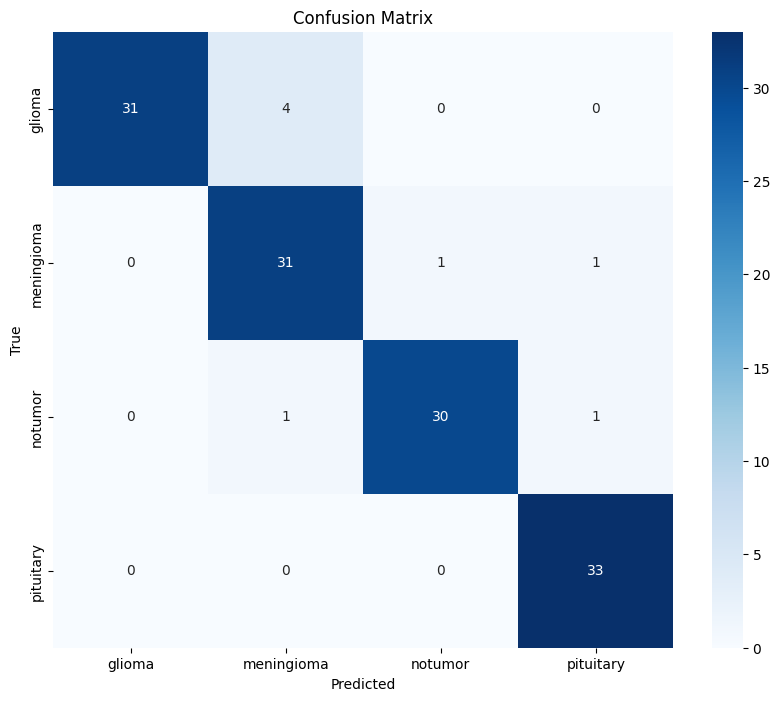

              precision    recall  f1-score   support

      glioma       1.00      0.89      0.94        35
  meningioma       0.86      0.94      0.90        33
     notumor       0.97      0.94      0.95        32
   pituitary       0.94      1.00      0.97        33

    accuracy                           0.94       133
   macro avg       0.94      0.94      0.94       133
weighted avg       0.94      0.94      0.94       133



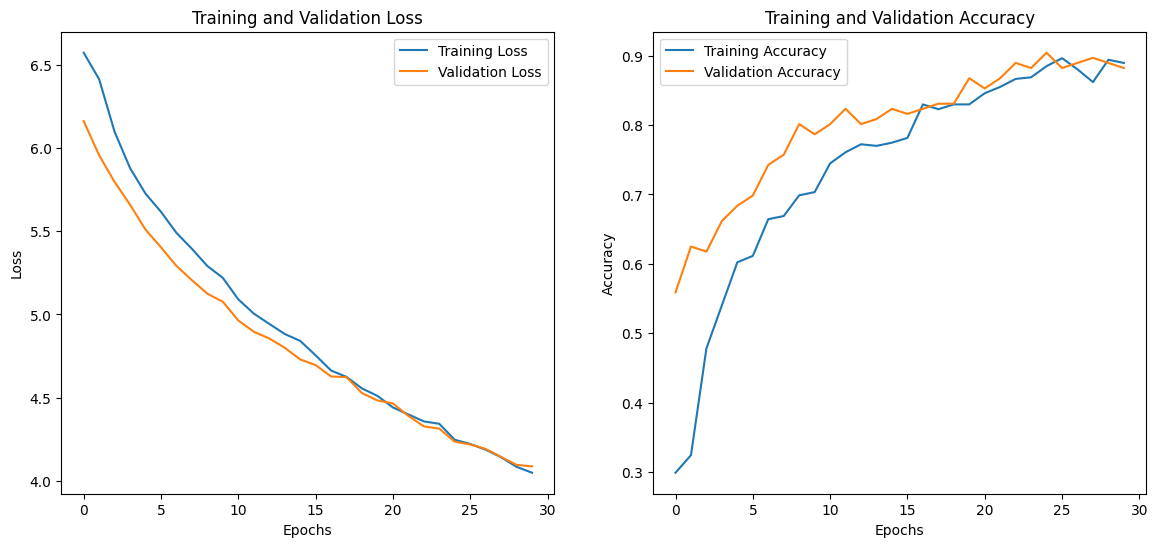

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_folder'

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

# Define paths and parameters
train_dataset_path = '/kaggle/working/dataset_split/train'
validation_dataset_path = '/kaggle/working/dataset_split/validation'
test_dataset_path = '/kaggle/working/dataset_split/test'
img_height, img_width = 224, 224
batch_size = 32
num_classes = 4

# Create ImageDataGenerators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to not shuffle for evaluation and predictions
)

# Load the VGG-16 model with pre-trained weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers except the top layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Plot training and validation loss and accuracy over epochs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Function to predict images in a folder
def predict_images_in_folder(folder_path, model, class_labels):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        img = load_img(image_path, target_size=(img_height, img_width))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_class]

        print(f'Image: {image_name} - Predicted Label: {predicted_label}')

# Example usage of predict_images_in_folder function
folder_path = 'path_to_your_folder'  # Replace with the path to your folder of images
predict_images_in_folder(folder_path, model, class_labels)

# Function to get random images from the dataset
def get_random_images(dataset_path, num_images=10):
    # Collect all image paths
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(root, file))
    
    # Randomly select image paths
    random_image_paths = random.sample(image_paths, num_images)
    
    return random_image_paths

# Function to display images
def display_images(image_paths):
    plt.figure(figsize=(20, 10))
    for i, image_path in enumerate(image_paths):
        img = load_img(image_path, target_size=(img_height, img_width))
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Get and display 10 random images from the dataset
random_image_paths = get_random_images(train_dataset_path, num_images=10)
display_images(random_image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Predicted Label: glioma
Prediction Probabilities: [[9.9582314e-01 7.1669213e-04 2.5806576e-03 8.7955821e-04]]


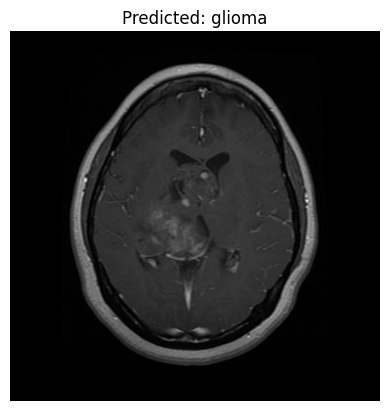

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale as per training data
    return img_array

# Function to predict the class of the image
def predict_image_class(image_path):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]
    return predicted_label, prediction

# Test the model with a single image
image_path = '/kaggle/working/dataset_split/train/glioma/Tr-gl_0381.jpg'  # Provide the path to the test image
predicted_label, prediction = predict_image_class(image_path)

print(f"Predicted Label: {predicted_label}")
print(f"Prediction Probabilities: {prediction}")

# Optionally, visualize the image and the prediction
import matplotlib.pyplot as plt
img = load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
